## Event reproducibility and functional connectivity in RSC
### data from Franco and Goard 2021
See the paper:    
*"A distributed circuit for associating environmental context with motor choice in retrosplenial cortex"*    
Luis M. Franco Michael J. Goard    
Science Advances 7, eabf9815 (2021). doi:10.1126/sciadv.abf9815

In [7]:
from platform import python_version
print(python_version())

%run -i 'imports_functions.py' 

%matplotlib inline

3.10.4


### Data preprocessing

The original file `twoPhotonData.mat` containing the DF/F traces is available on [Zenodo](https://zenodo.org/record/4734407/files/twoPhotonData.mat). We only use the first four sessions, to speed up the computations.

Here, to speed up the processing and reduce the dependencies, we use the Ca spiketrains extracted using the `deconvolve` function available in the library [OASIS](https://github.com/j-friedrich/OASIS/pull/19) (with all default parameters, and `penalty=1`).

In [8]:
if os.path.exists('goard/spiketrains_twoPhotonData.npy'):
    all_spiketrains = np.load('goard/spiketrains_twoPhotonData.npy', allow_pickle=True)
    time = np.load('goard/time_twoPhotonData.npy', allow_pickle=True) # all time samples
    print("... loaded",len(all_spiketrains), "spiketrains for", len(time), "intervals")

exp_path = os.getcwd() + "/goard/"

frame_duration = 0.1 # sec, 10 frames per second, see Methods in Franco and Goard 2021

... loaded 974 spiketrains for 20160 intervals


We separate the 4 sessions using the `cellsPerSession` field of the matlab file (here listed for simplicity).

In [9]:
cellsPerSession = [279, 136, 317, 242]

indices_cellsPerSession = np.cumsum(cellsPerSession)
print(indices_cellsPerSession)

sessions = np.split(all_spiketrains, indices_cellsPerSession)[:-1] # omit last empty split


[279 415 732 974]


## Dynamical analysis

Analysis for each session.

On average, the longest responses were for the 4th trial. We take it.



1/4
... loaded 279 spiketrains
... producing spike rasterplot per session
    population firing: 23.65±13.54 sp/frame
    cells firing rate: 0.08±0.28 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 49.56608855730683
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 17
    number of events per sec: 0.009086535891816773
    events duration: 0.800±0.348
    events size: 151.000±20.255
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.0
    cluster size threshold: 2
    Total number of clusters: 6
    # clusters (after removing those below reproducibility threshold): 2
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores firing unspecifically

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


    full adjacency matrix: (279, 279)
    preparing vertex labels for cores and others
    Degree distributions
    Local Clustering Coefficient (cores too)
... Flow Analysis
    Cut edges sourcing from cores: DescribeResult(nobs=264, minmax=(0.0, 0.24242424242424243), mean=0.010230142332415062, variance=0.0007380973496896924, skewness=4.452076074772766, kurtosis=26.311568177031056)
    Cut edges targeting cores: DescribeResult(nobs=264, minmax=(0.0, 0.20454545454545456), mean=0.010273186409550045, variance=0.0007141345844877881, skewness=4.22297858902832, kurtosis=21.538047402869616)
    Cut edges sourcing from others: DescribeResult(nobs=15, minmax=(0.0, 0.4), mean=0.035555555555555556, variance=0.011343915343915349, skewness=2.983569457903382, kurtosis=7.558142125194918)
    Cut edges targeting others: DescribeResult(nobs=15, minmax=(0.0, 0.3333333333333333), mean=0.02222222222222222, variance=0.007407407407407409, skewness=3.4743961448615157, kurtosis=10.071428571428575)
    Core t

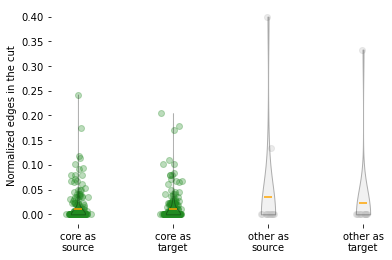

... PageRank centrality
    cores: DescribeResult(nobs=264, minmax=(0.0014517727169633579, 0.03166133933447958), mean=0.0037543276339300448, variance=1.4543486317513069e-05, skewness=2.7737934974047103, kurtosis=11.945498513948495)
    others: DescribeResult(nobs=15, minmax=(0.0, 0.0033883315574075967), mean=0.0005905003094978918, variance=1.5197588129789972e-06, skewness=1.562556632905865, kurtosis=0.5435049424480809)
    Kruskal-Wallis test:  27.337 p= 0.000
    Kolmogorov-Smirnov Effect Size: 0.800


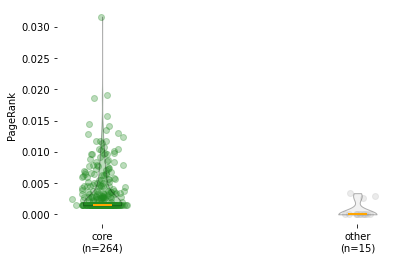

... Manifold Analysis
... Starting attractor analysis
    coloring frames
    finding trajectories
    trajectories lengths: -28.25±136.02 (median:11.50)
... performing dimensionality reduction of the state space (using PCA)
Silhouette Score:
0.3405087694223194
... testing cluster manifolds


2/4
... loaded 136 spiketrains
... producing spike rasterplot per session
    population firing: 10.12±7.95 sp/frame
    cells firing rate: 0.07±0.26 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 20.499916716344245
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 62
    number of events per sec: 0.03425982206995635
    events duration: 1.100±0.400
    events size: 71.500±20.697
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


    full adjacency matrix: (136, 136)
    preparing vertex labels for cores and others
    Degree distributions
    Local Clustering Coefficient (cores too)
... Flow Analysis
    Cut edges sourcing from cores: DescribeResult(nobs=129, minmax=(0.0, 5.0310077519379846), mean=0.32642269094405374, variance=0.6226340817766336, skewness=3.8143610511645116, kurtosis=16.882994406488088)
    Cut edges targeting cores: DescribeResult(nobs=129, minmax=(0.0, 4.395348837209302), mean=0.32179556517036234, variance=0.5015061785265588, skewness=3.3095178699308123, kurtosis=13.082692285467502)
    Cut edges sourcing from others: DescribeResult(nobs=7, minmax=(0.0, 23.0), mean=5.653061224489796, variance=81.78814382896016, skewness=1.2193652430343198, kurtosis=-0.1559586411825129)
    Cut edges targeting others: DescribeResult(nobs=7, minmax=(0.0, 23.714285714285715), mean=7.224489795918367, variance=83.2575315840622, skewness=0.83053276641988, kurtosis=-0.6466039388283917)
    Core targets vs sources W

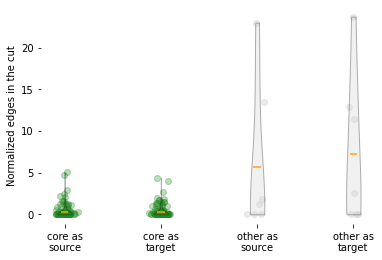

... PageRank centrality
    cores: DescribeResult(nobs=129, minmax=(0.0021247689192534455, 0.05917852949265631), mean=0.007572690774441039, variance=0.00010276854889861286, skewness=2.9819201093304226, kurtosis=10.347886714716338)
    others: DescribeResult(nobs=7, minmax=(0.0, 0.007721351999322401), mean=0.0033032700138722953, variance=1.0806740778420721e-05, skewness=0.05768359794532489, kurtosis=-1.6129608044735497)
    Kruskal-Wallis test:  1.470 p= 0.225
    Kolmogorov-Smirnov Effect Size: 0.429


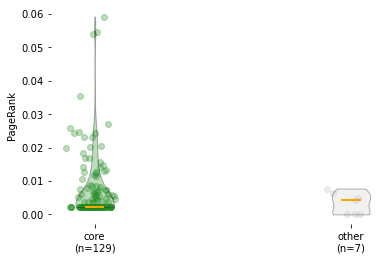

... Manifold Analysis
... Starting attractor analysis
    coloring frames
    finding trajectories
    trajectories lengths: 13.42±26.13 (median:15.00)
... performing dimensionality reduction of the state space (using PCA)
Silhouette Score:
0.4423954708957491
... testing cluster manifolds


3/4
... loaded 317 spiketrains
... producing spike rasterplot per session
    population firing: 21.75±16.91 sp/frame
    cells firing rate: 0.07±0.25 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 50.10801488048076
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 36
    number of events per sec: 0.017858028672057144
    events duration: 1.000±0.457
    events size: 179.000±30.858
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


    full adjacency matrix: (317, 317)
    preparing vertex labels for cores and others
    Degree distributions
    Local Clustering Coefficient (cores too)
... Flow Analysis
    Cut edges sourcing from cores: DescribeResult(nobs=293, minmax=(0.0, 2.7918088737201363), mean=0.36410441589302145, variance=0.2815981086745918, skewness=2.0582393921386313, kurtosis=4.54063538439174)
    Cut edges targeting cores: DescribeResult(nobs=293, minmax=(0.0, 2.453924914675768), mean=0.3643024380016075, variance=0.2692548690815931, skewness=1.7668979642675493, kurtosis=2.59571929682094)
    Cut edges sourcing from others: DescribeResult(nobs=24, minmax=(0.0, 0.7916666666666666), mean=0.203125, variance=0.06315104166666666, skewness=1.1269730214557472, kurtosis=0.04695058284902398)
    Cut edges targeting others: DescribeResult(nobs=24, minmax=(0.0, 0.625), mean=0.17361111111111113, variance=0.03980475040257649, skewness=0.9726405938725359, kurtosis=-0.11554450270984828)
    Core targets vs sources We

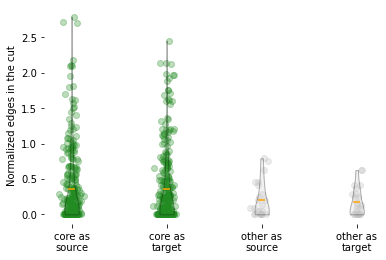

... PageRank centrality
    cores: DescribeResult(nobs=293, minmax=(0.000714813138373914, 0.019268889596278163), mean=0.0033948114764955155, variance=8.304242618188085e-06, skewness=1.346316985885559, kurtosis=3.00549253953064)
    others: DescribeResult(nobs=24, minmax=(0.0, 0.0006574099243365658), mean=0.00022167655778391215, variance=4.628552518173054e-08, skewness=0.7199141428649576, kurtosis=-0.6008477316762582)
    Kruskal-Wallis test:  67.790 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


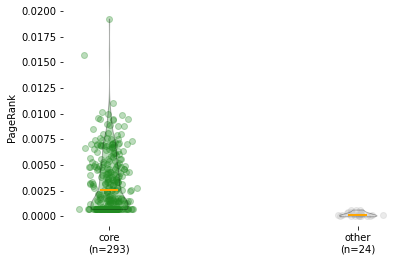

... Manifold Analysis
... Starting attractor analysis
    coloring frames
    finding trajectories
    trajectories lengths: 14.29±13.31 (median:11.50)
... performing dimensionality reduction of the state space (using PCA)
Silhouette Score:
0.4850710405244886
... testing cluster manifolds


4/4
... loaded 242 spiketrains
... producing spike rasterplot per session
    population firing: 21.69±11.37 sp/frame
    cells firing rate: 0.09±0.29 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 49.09044410048601
    find peaks
    find minima
    find population events
... not enough events to continue analysis (<5)
    signatures of population events
    number of events: 4
    number of events per sec: 0.0021362956633198035
    events duration: 0.950±0.286
    events size: 112.000±40.127
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded su

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


    full adjacency matrix: (242, 242)
    preparing vertex labels for cores and others
    Degree distributions
    Local Clustering Coefficient (cores too)
... Flow Analysis
    Cut edges sourcing from cores: DescribeResult(nobs=176, minmax=(0.0, 0.045454545454545456), mean=0.002485795454545454, variance=4.230233544864227e-05, skewness=3.810094929023084, kurtosis=17.483526761866617)
    Cut edges targeting cores: DescribeResult(nobs=176, minmax=(0.0, 0.05113636363636364), mean=0.0028086260330578514, variance=5.4972387504024916e-05, skewness=3.9814722081157647, kurtosis=18.803691202166515)
    Cut edges sourcing from others: DescribeResult(nobs=66, minmax=(0.0, 0.045454545454545456), mean=0.0039026629935720843, variance=0.00010814866186767015, skewness=2.790860467367489, kurtosis=7.033527966250459)
    Cut edges targeting others: DescribeResult(nobs=66, minmax=(0.0, 0.030303030303030304), mean=0.0016069788797061526, variance=3.6227928789912267e-05, skewness=3.871924165126357, kurtosis=

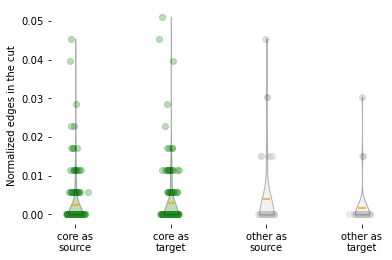

... PageRank centrality
    cores: DescribeResult(nobs=176, minmax=(0.00173821604266243, 0.02716102123802192), mean=0.005034414584641716, variance=2.5586437725553306e-05, skewness=1.8066529710525219, kurtosis=3.216680281244253)
    others: DescribeResult(nobs=66, minmax=(0.0, 0.012054864789471662), mean=0.0017264095924705754, variance=9.9843732134693e-06, skewness=2.023435292814704, kurtosis=2.99595168302978)
    Kruskal-Wallis test:  57.238 p= 0.000
    Kolmogorov-Smirnov Effect Size: 0.712


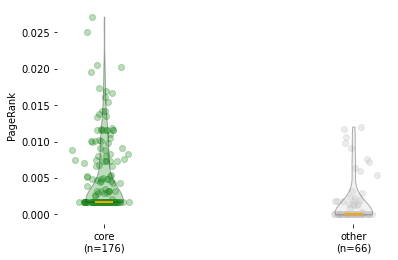

... Manifold Analysis
... Starting attractor analysis
    coloring frames
    finding trajectories
    trajectories lengths: -543.25±956.53 (median:7.00)
... performing dimensionality reduction of the state space (using PCA)
Silhouette Score:
0.36481970838913585
... testing cluster manifolds


In [12]:
global_events = [[] for i in range(len(sessions))] # by session
global_events_vector = [[] for i in range(len(sessions))] # by session
global_events_sec = []
global_events_duration = []
global_cluster_number = []
global_cluster_selfsimilarity = [[] for i in range(len(sessions))]

core_reproducibility_perc = 99. # threshold for detecting cores

all_degrees = []
all_core_degrees = []
all_local_clustering_coefficients = []
all_core_local_clustering_coefficients = []
all_pagerank_cores = []
all_pagerank_others = []

for scan_id,scan_spiketrains in enumerate(sessions):
    print("\n\n%d/%d" % (scan_id+1,len(sessions)))
    print("... loaded %s spiketrains"%(len(scan_spiketrains)))
    
    # we only take trial 4, starting at 1500 sec
    scan_spiketrains = [ np.nan_to_num(st[np.argwhere(np.array(st)>1500)[0][0]:], nan=0., posinf=0., neginf=0.).tolist() for st in scan_spiketrains]

    start_time = 1500
    exp_tstart = start_time
    stop_time = max([max(st) if len(st) else 0 for st in scan_spiketrains])
    
    print("... producing spike rasterplot per session")
    fig = plt.figure()
    for row,train in enumerate(scan_spiketrains):
        plt.scatter( train, [row]*len(train), marker='o', edgecolors='none', s=1, c='k' )
    plt.ylabel("cell IDs")
    plt.xlabel("time (s)")
    fig.savefig(exp_path+'/results/rasterplot_twoPhotonData_scan%s.png'%scan_id, transparent=True, dpi=800)
    plt.close()
    # fig.clear()
    # fig.clf()
    
    ophys_cell_ids = list(range(len(scan_spiketrains)))
    ophys_cell_indexes = ophys_cell_ids # alias
    
    # --------------------------------------------------------------------------
    %run "dynamical_analysis.ipynb"

    global_events[scan_id].extend(events)
    global_events_vector[scan_id].extend(events_vectors)
    global_events_sec.append(events_sec)
    global_events_duration.extend(events_durations_f)
    global_cluster_number.append(nclusters)
    global_cluster_selfsimilarity.extend(reproducibility_list)

    # --------------------------------------------------------------------------
    # Functional structure analysis
    spiketrains = scan_spiketrains
    perc_corr = 0.6 # discard correlations below
    %run "functional_analysis.ipynb"
    all_degrees.extend(degrees)
    all_core_degrees.extend(core_degrees)
    all_local_clustering_coefficients.extend(local_clustering_coefficients)
    all_core_local_clustering_coefficients.extend(core_local_clustering_coefficients)
    all_pagerank_cores.extend(pagerank_cores)
    all_pagerank_others.extend(pagerank_others)

    # --------------------------------------------------------------------------
    # dimensional reduction, trajectories, and manifold analysis
    mousename = '0'
    area = 'RSC'
    ipop = scan_id
    print("... Manifold Analysis")
    %run "attractor_analysis.ipynb"


... Total modularity
    Total PageRank centrality
    cores: DescribeResult(nobs=862, minmax=(0.000714813138373914, 0.05917852949265631), mean=0.004464914541497163, variance=2.979512056811689e-05, skewness=4.319331799988412, kurtosis=30.05345957631026)
    others: DescribeResult(nobs=112, minmax=(0.0, 0.012054864789471662), mean=0.0013503898681200565, variance=7.310191052640849e-06, skewness=2.4007285309282778, kurtosis=5.1017198596142475)
    Kruskal-Wallis test:  133.939 p= 0.000000
    Kolmogorov-Smirnov Effect Size: 0.714


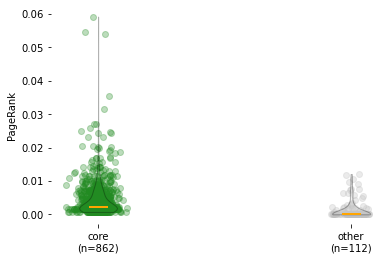

In [11]:
# Total modularity
print('... Total modularity')
# figure
fig, (hmmap, chist) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [6, 1]})
# hierarchy
hmmap.scatter( all_degrees, all_local_clustering_coefficients, marker='o', facecolor='#111111', s=50, edgecolors='none', alpha=0.5) 
hmmap.set_yscale('log')
hmmap.set_ylim([0.02,1.1])
hmmap.set_xscale('log')
hmmap.spines['top'].set_visible(False)
hmmap.spines['right'].set_visible(False)
hmmap.set_ylabel('LCC')
hmmap.set_xlabel('degree')
hmmap.tick_params(axis='both', bottom='on', top='on', left='off', right='off')
# core lcc histogram
bins = np.linspace(0.02,1,50)
barheight = (max(all_local_clustering_coefficients)-min(all_local_clustering_coefficients))/50
lcc_hist, lcc_binedges = np.histogram(all_core_local_clustering_coefficients, bins)
chist.barh(bins[:-1], lcc_hist, height=barheight, align='center', color='green', linewidth=0)
chist.spines['top'].set_visible(False)
chist.spines['right'].set_visible(False)
chist.tick_params(axis='x', which='both', bottom=True, top=False, labelsize='x-small')
chist.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
chist_ticks = chist.get_xticks()
chist.set_ylim([0.01,1.1])
chist.set_ylabel('LCC')
chist.set_xlabel('count')
chist.yaxis.set_label_position("right")
chist.spines['top'].set_visible(False)
chist.spines['right'].set_visible(False)
chist.spines['bottom'].set_visible(False)
plt.tight_layout()
fig.savefig(exp_path+"/results/cores_hierarchical_modularity_all.svg", transparent=True)
plt.close()
fig.clear()
fig.clf()

# totals
if len(all_pagerank_cores)>0 and len(all_pagerank_others)>0:
    print('    Total PageRank centrality')
    # description
    print("    cores: "+str(stats.describe(all_pagerank_cores)) )
    print("    others: "+str(stats.describe(all_pagerank_others)) )
    # significativity
    print("    Kruskal-Wallis test:  %.3f p= %f" % stats.kruskal(all_pagerank_cores, all_pagerank_others))
    d,_ = stats.ks_2samp(all_pagerank_cores, all_pagerank_others) # non-parametric measure of effect size [0,1]
    print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)

    fig, ax = plt.subplots()
    xs = np.random.normal(1, 0.04, len(all_pagerank_cores))
    plt.scatter(xs, all_pagerank_cores, alpha=0.3, c='forestgreen')
    xs = np.random.normal(2, 0.04, len(all_pagerank_others))
    plt.scatter(xs, all_pagerank_others, alpha=0.3, c='silver')
    vp = ax.violinplot([all_pagerank_cores,all_pagerank_others], widths=0.15, showextrema=False, showmedians=True)
    for pc in vp['bodies']:
        pc.set_edgecolor('black')
    for pc,cb in zip(vp['bodies'],['#228B224d','#D3D3D34d']):
        pc.set_facecolor(cb)
    vp['cmedians'].set_color('orange')
    vp['cmedians'].set_linewidth(2.)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.ylabel('PageRank')
    plt.xticks([1, 2], ["core\n(n={:d})".format(len(all_pagerank_cores)), "other\n(n={:d})".format(len(all_pagerank_others))])
    fig.savefig(exp_path+"/results/global_cores_others_pagerank_all.svg", transparent=True)
    plt.show()
